In [1]:
import numpy as np
import matplotlib.pyplot as pl
from scipy import integrate
from mpmath import mp
mp.dps = 50

# import warnings
# warnings.filterwarnings('ignore')

t0 = 0.0
x0 = 300.0
v = 2.0
epsilon = 0.1

In [2]:
ls = 2**13
data = np.fromfile('bypartsII/X.bin')
lt = np.shape(data)[0]//(3*ls)
data = data.reshape(np.shape(data)[0]//3, 3)
space = np.zeros((ls))
time = np.zeros((lt))
phi1 = np.zeros((lt,ls))
for i in range ((lt)):
    time[i] = data[ls*i,0]
    
for i in range ((ls)):
    space[i] = data[i,1]
    
for i in range ((lt)):
    for j in range ((ls)):
        phi1[i,j] = data[ls*i+j,2]

\begin{equation}
	\large x_c = x_0 + v (t - t_0), \qquad u = \frac{\sqrt{v}}{2} (x - x_c), \qquad \varphi ^{(0)} = \frac{v}{2} \text{sech} ^2 u
\end{equation}

In [3]:
def sech(x):
    return 1/np.cosh(x)

def xc(t):
    return x0 + v*(t - t0)

def u(t, x):
    return (np.sqrt(v)/2) * (x - xc(t))

def soliton(t, x):
    return (v/2) * sech(u(t, x))**2

\begin{equation}
    \large \lambda = (\lambda ^1 , \lambda ^2) = (x_c , v) ; \qquad \beta ^{(0)} = ( v , 0 )
\end{equation}

\begin{equation}
    \large \frac{\partial \varphi ^{(0)}}{\partial \lambda ^1} = \frac{\partial \varphi ^{(0)}}{\partial x_c} = \frac{v^{3/2}}{2} \text{sech}^2 u \tanh u , \qquad \frac{\partial \varphi ^{(0)}}{\partial \lambda ^2} = \frac{\partial \varphi ^{(0)}}{\partial v} = \frac{1}{2} \text{sech}^2 u [1 - u \tanh u]
\end{equation}

In [4]:
def phi0_1(t, x):
    return (v**(3/2)/2) * sech(u(t, x))**2 * np.tanh(u(t, x))

def phi0_2(t, x):
    return (1/2) * sech(u(t, x))**2 * (1 - u(t, x) * np.tanh(u(t, x)))

\begin{gather}
    \large e^{(0)}_1 = (t - t_0) \frac{\partial \varphi ^{(0)}}{\partial \lambda ^1}, \qquad e^{(0)}_2 = \frac{1}{2} (t - t_0)^2 \frac{\partial \varphi ^{(0)}}{\partial \lambda ^1} + (t - t_0) \frac{\partial \varphi ^{(0)}}{\partial \lambda ^2}, \\
    \large e^{(1)}_1 = \frac{\partial \varphi ^{(0)}}{\partial \lambda ^1}, \qquad e^{(1)}_2 = (t - t_0) \frac{\partial \varphi ^{(0)}}{\partial \lambda ^1} + \frac{\partial \varphi ^{(0)}}{\partial \lambda ^2}
\end{gather}

In [5]:
def e0_1(ti): # ti: time index
    return (time[ti] - t0) * phi0_1(time[ti], space)
    
def e0_2(ti):
    return 0.5 * (time[ti] - t0)**2 * phi0_1(time[ti], space) + (time[ti] - t0) * phi0_2(time[ti], space)

def e1_1(ti):
    return phi0_1(time[ti], space)

def e1_2(ti):
    return (time[ti] - t0) * phi0_1(time[ti], space) + phi0_2(time[ti], space)

In [6]:
def space_integration(f): # T: time index, total time
    return integrate.simpson(f, space, even='avg')

\begin{equation}
    \large M ^{(\mu )(\nu )}_{ij} = \int dt \, dx \, e^{(\mu )}_i e^{(\nu )}_j = \int dt \, m ^{(\mu )(\nu )}_{ij}, \qquad
    \large m ^{(\mu) (\nu)}_{ij} = \int dx \, e^{(\mu )}_i e^{(\nu )}_j = \begin{pmatrix}
    m ^{(0) (0)}_{22} & m ^{(0)(1)}_{21} & m ^{(0)(1)}_{22} \\
    m ^{(1) (0)}_{12} & m ^{(1)(1)}_{11} & m ^{(1)(1)}_{12} \\
    m ^{(1) (0)}_{22} & m ^{(1)(1)}_{21} & m ^{(1)(1)}_{22}
    \end{pmatrix}
\end{equation}

In [7]:
# ti: time index
# mu = nu = 0

def m00_22(ti):
    return space_integration(e0_2(ti)**2)

# mu = 0, nu = 1

def m01_21(ti):
    return space_integration(e0_2(ti) * e1_1(ti))

def m01_22(ti):
    return space_integration(e0_2(ti) * e1_2(ti))

# mu = 1, nu = 0

def m11_11(ti):
    return space_integration(e1_1(ti)**2)

def m11_12(ti):
    return space_integration(e1_1(ti) * e1_2(ti))

def m11_22(ti):
    return space_integration(e1_2(ti)**2)

In [8]:
T = lt - 1
# pl.plot(time[:T], [ m00_22(i) for i in range(T) ], label=r'$m^{(0)(0)}_{22}$')
# pl.legend()

\begin{equation}
    \large M ^{(\mu) (\nu)}_{ij}= \begin{pmatrix}
    M ^{(0) (0)}_{22} & M ^{(0)(1)}_{21} & M ^{(0)(1)}_{22} \\
    M ^{(1) (0)}_{12} & M ^{(1)(1)}_{11} & M ^{(1)(1)}_{12} \\
    M ^{(1) (0)}_{22} & M ^{(1)(1)}_{21} & M ^{(1)(1)}_{22}
    \end{pmatrix}
\end{equation}

In [9]:
def time_integration(func, T): # T: time index, total time
    return integrate.simpson([ func(i) for i in range(T) ], time[:T], even='avg')

In [10]:
def M(T): # T: time index, total time
    MM = np.array([time_integration(m00_22, T), time_integration(m01_21, T), time_integration(m01_22, T), time_integration(m11_11, T), time_integration(m11_12, T), 
                   time_integration(m11_22, T)])
    return np.array([[MM[0], MM[1], MM[2]],
                     [MM[1], MM[3], MM[4]],
                     [MM[2], MM[4], MM[5]]])

\begin{equation}
    \large V ^{(\nu )}_{i} = \int dt \, dx \, e^{(\nu )}_i \varphi ^{(1)} = \int dt \, v ^{(\nu )}_{i}
\end{equation}

In [11]:
# ti: time index
def v0_2(ti):
    return space_integration(e0_2(ti) * phi1[ti])

def v1_1(ti):
    return space_integration(e1_1(ti) * phi1[ti])

def v1_2(ti):
    return space_integration(e1_2(ti) * phi1[ti])

In [12]:
def V(T): # T: time index, total time
    return np.array([[time_integration(v0_2, T)],
                     [time_integration(v1_1, T)],
                     [time_integration(v1_2, T)]])

\begin{equation}
    \large \psi ^{i (\mu)} = ((M^{-1})^{(\mu)(\nu)})^{ij} V_j^{(\nu)}
\end{equation}

In [13]:
def psi(T): # T: time index, total time
    MM = mp.matrix(M(T).tolist())
    MMp = MM**-1
    return np.matmul(np.array(MMp.tolist(), dtype = np.float64), V(T))

In [14]:
TT = [ 500 , 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000 ]
# TT = [ 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000 ]
PP = [ psi(tt) for tt in TT ]

/tmp/ipykernel_54764/240725466.py:2: RuntimeWarning: overflow encountered in cosh
  return 1/np.cosh(x)


Text(0.5, 1.0, '$v = 0.0625$')

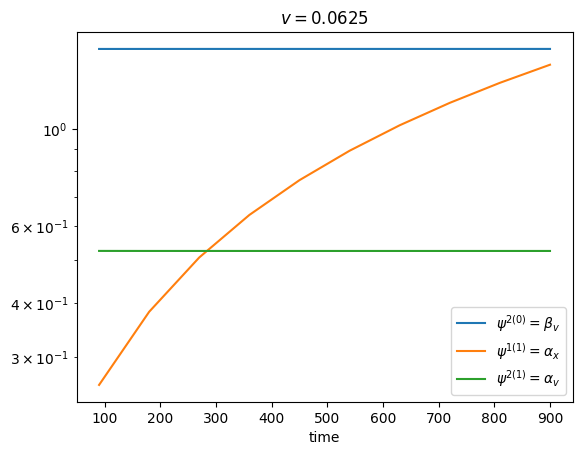

In [15]:
pl.plot(time[TT], np.abs([ PP[i][0, 0] for i in range(len(TT)) ]), label=r'$\psi ^{2(0)} = \beta _v $')
pl.plot(time[TT], np.abs([ PP[i][1, 0] for i in range(len(TT)) ]), label=r'$\psi ^{1(1)} = \alpha _x $')
pl.plot(time[TT], np.abs([ PP[i][2, 0] for i in range(len(TT)) ]), label=r'$\psi ^{2(1)} = \alpha _v $')

pl.legend()
pl.yscale('log')
pl.xlabel('time')
pl.title(r'$v = 0.0625$')
# pl.savefig('kdv-v2_0.png')

\begin{equation}
    \large \varphi ^{(1)} _{\perp} = \varphi ^{(1)} - \psi ^{j (\mu )} e^{(\mu )}_j
\end{equation}

In [16]:
P = PP[-1]
print(P)
I = phi1[T] - (P[0][0]*e0_2(T) + P[1][0]*e1_1(T) + P[2][0]*e1_2(T))

[[-1.52377546]
 [ 1.40202837]
 [ 0.52545797]]


/tmp/ipykernel_54764/240725466.py:2: RuntimeWarning: overflow encountered in cosh
  return 1/np.cosh(x)


In [17]:
def phi_ort(i):
    return phi1[i] - (-1.5238078772641095*e0_2(i) + 2.8791916183193003*e1_1(i) + 0.5254467697550285*e1_2(i))

/tmp/ipykernel_54764/240725466.py:2: RuntimeWarning: overflow encountered in cosh
  return 1/np.cosh(x)


(2000.0, 2400.0)

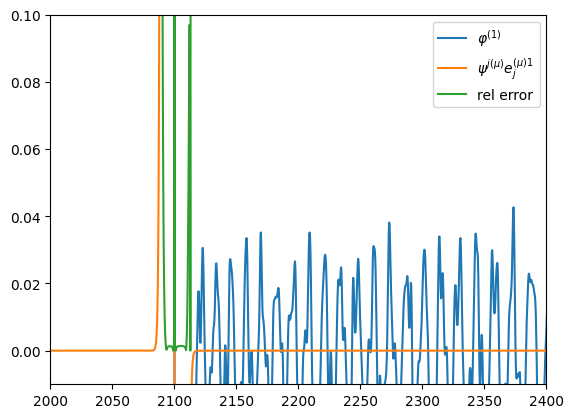

In [18]:
pl.plot(space, phi1[T], label=r'$\varphi ^{(1)} $')
pl.plot(space, P[0][0]*e0_2(T) + P[1][0]*e1_1(T) + P[2][0]*e1_2(T), label=r'$\psi ^{j (\mu )} e^{(\mu ) 1}_j$')
pl.plot(space, np.abs(I/phi1[T]), label=r'rel error')
pl.ylim(-0.01, 0.1)

# pl.plot(space, I, label=r'$\varphi ^{(1) 1} _{\perp}$')
pl.legend()
pl.xlim(2000, 2400)
# pl.title(r'$v = 2.0$')
# pl.savefig('kdv-v2_0-error.png')

In [19]:
data2 = np.fromfile('lambdaR.bin')
lt2 = np.shape(data2)[0]//3
vR = np.zeros((lt2))
xR = np.zeros((lt2))
# time2 = np.zeros((lt2))

for i in range ((lt2)):
    # time2[i] = data2[3*i]
    vR[i] = data2[3*i + 1]
    xR[i] = data2[3*i + 2] 

In [20]:
def uu(i, x):
    return (np.sqrt(vR[i])/2) * (x - xR[i])

def ren_soliton(i, x):
    return (vR[i]/2) * np.cosh(uu(i, x))**(-2)

/tmp/ipykernel_54764/240725466.py:2: RuntimeWarning: overflow encountered in cosh
  return 1/np.cosh(x)


(0.0, 0.1)

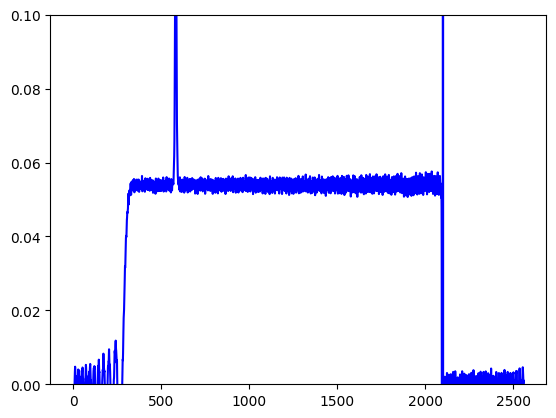

In [21]:
# for i in range(4999, 5000):
#     pl.plot(space, epsilon*phi_ort(i) + ren_soliton(i, space), color='blue')
pl.plot(space, 0.1*phi_ort(T) + ren_soliton(T, space), color='blue')
pl.ylim(0, 0.1)

In [22]:
data3 = np.fromfile('soliton.bin')
data3 = data3.reshape(np.shape(data3)[0]//3, 3)
# space = np.zeros((ls))
# time = np.zeros((lt))
phi = np.zeros((lt,ls))
# for i in range ((lt)):
    # time[i] = data3[ls*i,0]
    
# for i in range ((ls)):
    # space[i] = data[i,1]
    
for i in range ((lt)):
    for j in range ((ls)):
        phi[i,j] = data3[ls*i+j,2]

/tmp/ipykernel_54764/240725466.py:2: RuntimeWarning: overflow encountered in cosh
  return 1/np.cosh(x)


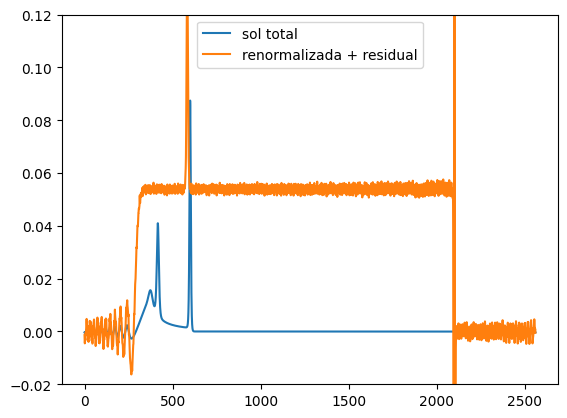

In [24]:
pl.plot(space, phi[T,:], label = "sol total")
pl.plot(space, epsilon*phi_ort(T) + ren_soliton(T, space), label = "renormalizada + residual")
# pl.xlim(250.0, 450.0)
pl.ylim(-0.02, 0.12)
pl.legend()

/tmp/ipykernel_54764/240725466.py:2: RuntimeWarning: overflow encountered in cosh
  return 1/np.cosh(x)
/tmp/ipykernel_54764/2476205574.py:5: RuntimeWarning: overflow encountered in cosh
  return (vR[i]/2) * np.cosh(uu(i, x))**(-2)


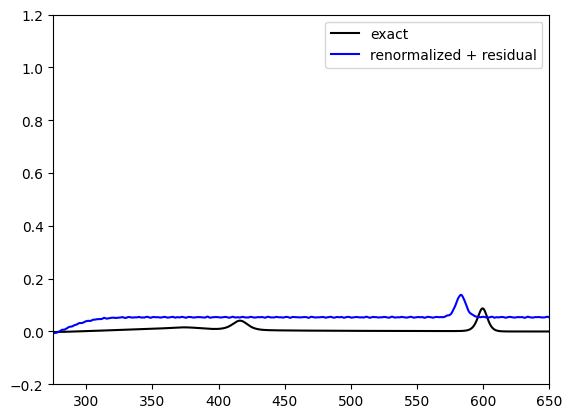

In [26]:
from matplotlib.animation import FuncAnimation

fig, aax = pl.subplots()
xdata, ydata = [], []
xdata2,ydata2= [], []
ln, = pl.plot([], [], '-k', label='exact') 
ln2, = pl.plot([], [], '-b', label='renormalized + residual')
pl.legend()

def init():
    aax.set_xlim(275, 650)
    aax.set_ylim(-0.2, 1.2)
    ln.set_data([], [])
    ln2.set_data([], [])
    return ln,ln2

def animate(i):
    ln.set_data(space, phi[i,:])
    ln2.set_data(space, epsilon*phi_ort(i) + ren_soliton(i, space))
    return ln,ln2

anim = FuncAnimation(fig, animate, init_func=init, frames=len(time), blit=True)
anim.save('ren2.mp4', writer='ffmpeg', fps=200)